In [ ]:
%load_ext autoreload
%autoreload 2
import notebook_setup # needed for Jupyter notebooks

import  src.init
import  emcee
import  corner
import  numpy                   as np 
import  matplotlib.pyplot       as plt
from    math                    import inf
from    pathlib                 import Path
from    src.top_hat.montecarlo  import *
from    src.top_hat.plot           import TopHatPlotter

import  matplotlib.colors as mcolors
from    matplotlib.patches import Patch
plt.style.use('../configurations/style.mplstyle')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
datafiles   = Path("../datafiles")
N_WALKERS   = 20

# Universal Top-Hat

In [9]:
# Model configuration
N_PARAMS        = 6
PARAM_NAMES     = ["A_index", "L_L0", "L_mu_E", "sigma_E", "theta_c_deg", "f_j"]
THETA_MAX_DEG   = 25 # degrees
MAX_FJ          = 10

def log_prior(thetas):
    A_index, L_L0, L_mu_E, sigma_E, theta_c_deg, fj = thetas
    
    if not (1.5 < A_index       < 12)               : return -inf
    if not (-2  < L_L0          < 6)                : return -inf
    if not (1   < L_mu_E        < 6.5)              : return -inf
    if not (0   < sigma_E       < 1.8)              : return -inf
    if not (0   < theta_c_deg   < THETA_MAX_DEG)    : return -inf
    if not (0   < fj            < MAX_FJ)           : return -inf

    return 0.0 # Uniform prior

def log_likelihood_default(thetas, params_in, distances, k_interpolator, n_events=10_000):
    """
    Simulate exactly n_years of GRB observations.
    """
    A_index, L_L0, L_mu_E, sigma_E, theta_c_deg, fj = thetas

    # Calculate epsilon from f_j and theta_c
    theta_c_rad             = np.radians(theta_c_deg)
    geometric_factor        = 1 - np.cos(theta_c_rad)
    epsilon                 = fj * geometric_factor

    gbm_eff                 = 0.6
    
    # Calculate expected number of GRBs for n_years
    n_years                 = params_in.triggered_years 
    intrinsic_rate_per_year = epsilon * len(params_in.z_arr) * gbm_eff
    expected_total_events   = intrinsic_rate_per_year * n_years
    
    if expected_total_events < 10:
        return -inf, -inf, -inf, -inf, -inf

    results                     = simplified_montecarlo(thetas, n_events, params_in, distances, k_interpolator)
    
    trigger_mask, analysis_mask = apply_detection_cuts(results["p_flux"], results["E_p_obs"])
    
    if np.sum(analysis_mask) <= 3:
        return -inf, -inf, -inf, -inf, -inf
    
    detected_events         = np.sum(trigger_mask)
    detection_efficiency    = detected_events / n_events

    predicted_detections    = expected_total_events * detection_efficiency

    # Observed detections in the actual catalog
    observed_detections     = params_in.yearly_rate * params_in.triggered_years

    l1                      = score_func_cvm(results["p_flux"][analysis_mask], params_in.pflux_data, params_in.rng)
    l2                      = score_func_cvm(results["E_p_obs"][analysis_mask], params_in.epeak_data, params_in.rng)
    l3                      = poiss_log(k=observed_detections, mu=predicted_detections)
    l4                      = np.sum(trigger_mask) / n_events
    
    return l1 + l2 + l3, l1, l2, l3, l4

def initialize_walkers(n_walkers):
    np.random.seed(42)
    return np.column_stack([
        np.random.uniform(2, 3, n_walkers),           # A_index
        np.random.uniform(2, 4.0, n_walkers),         # L_L0
        np.random.uniform(2.0, 4.0, n_walkers),       # L_mu_E
        np.random.uniform(0.2, 1, n_walkers),         # sigma_E
        np.random.uniform(1, 15, n_walkers),          # theta_c_deg ← NEW!
        np.random.uniform(0.5, 2, n_walkers),         # f_j ← NEW!
    ])

In [51]:
# Where to find the datafiles and save the outputs
output_dir_eps  = src.init.create_run_dir(f"run_test_top_hat")
params = {
    "alpha"         : -0.67,    # 2/3 from synchrotron
    "beta_s"        : -2.59,    # Average value from GRBs
    "n"             : 2,        # Smoothly broken power law curvature
    "theta_c"       : 3.4,      # Ghirlanda half-angle of jet core (from GW170817)
    "theta_v_max"   : 10,       # Maximum viewing angle of the jet (in degrees)
    "z_model"      : 'fiducial_Hrad_A1.0'    #? Optional, model to use for redshift distribution
}
default_params, _, data_dict = src.init.initialize_simulation(datafiles, params=params) #? Catalogue data from fermi GBM

print(f"Total events in the catalogue: {len(default_params.pflux_data)}")

n_walkers       = 20
n_steps         = 30_000

k_interpolator  = create_k_interpolator()

log_likelihood_default_in = create_log_probability_function(
    log_prior_func          =   log_prior,
    log_likelihood_func     =   log_likelihood_default,
    params_in               =   default_params,
    k_interpolator          =   k_interpolator
)

filename    = output_dir_eps / "emcee.h5"
initial_pos, n_steps, backend = check_and_resume_mcmc(
    filename    =   filename, 
    n_steps     =   n_steps, 
    initialize_walkers_func   =   initialize_walkers, 
    n_walkers   =   n_walkers
) 

sampler = run_mcmc(
    log_probability_func    =   log_likelihood_default_in,
    initial_walkers         =   initial_pos,
    n_iterations            =   n_steps,
    n_walkers               =   n_walkers,
    n_params                =   N_PARAMS,
    backend                 =   backend,
)

Loading existing directory  : Output_files/run_test_top_hat
Using redshift model: samples_fiducial_Hrad_A1.0_BNSs_0.dat with 359079 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
Total events in the catalogue: 268
Continuing from iteration 26000


100%|██████████| 4000/4000 [04:18<00:00, 15.47it/s]


In [52]:
backend     = emcee.backends.HDFBackend(output_dir_eps / "emcee.h5")

In [53]:
# Cell: Plotting results
# After running MCMC
plotter         = TopHatPlotter(
    backend     =   backend,
    output_dir  =   output_dir_eps,
    model_type  =   "theta_c",  # or "flat_theta", "lognormal_theta"
    burn_in     =   10_000,
    thin        =   15
)

# Generate all plots
distances = compute_luminosity_distance(default_params.z_arr)
summary = plotter.generate_all_plots(
    mc_func         =   simplified_montecarlo,
    params_in       =   default_params,
    distances       =   distances,
    k_interpolator  =   k_interpolator
)

print(summary)  # Print LaTeX table

Generating corner plot...
(26660, 6)
Generating likelihood evolution...
Generating autocorrelation plot...
Generating corner plot for last two parameters...
Generating CDF comparison...
All plots saved to: Output_files/run_test_top_hat
\begin{tabular}{lc}
\hline
Parameter & Value \\
\hline
$k$ & $5.216_{-2.131}^{+3.956}$ \\
$\log_{10}(L_0)$ & $3.151_{-0.659}^{+0.508}$ \\
$\log_{10}(\mu_E)$ & $3.430_{-0.187}^{+0.804}$ \\
$\sigma_E$ & $0.405_{-0.091}^{+0.271}$ \\
$\theta_c$ (deg) & $3.368_{-2.232}^{+12.631}$ \\
$f_j$ & $2.562_{-2.141}^{+4.162}$ \\
\hline
\end{tabular}


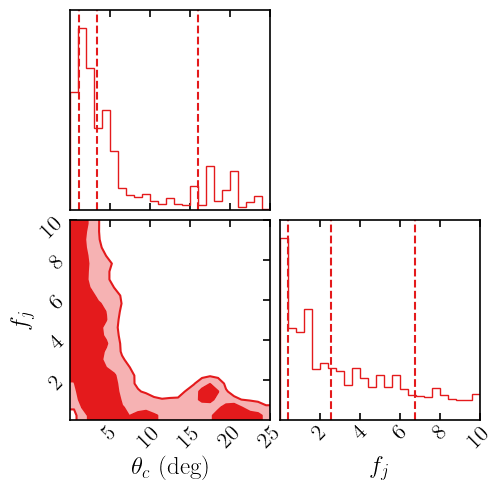

In [54]:
plotter.plot_corner_last_two()

Saved plot to Output_files/run_test_top_hat/degeneracy_concept_plot.pdf


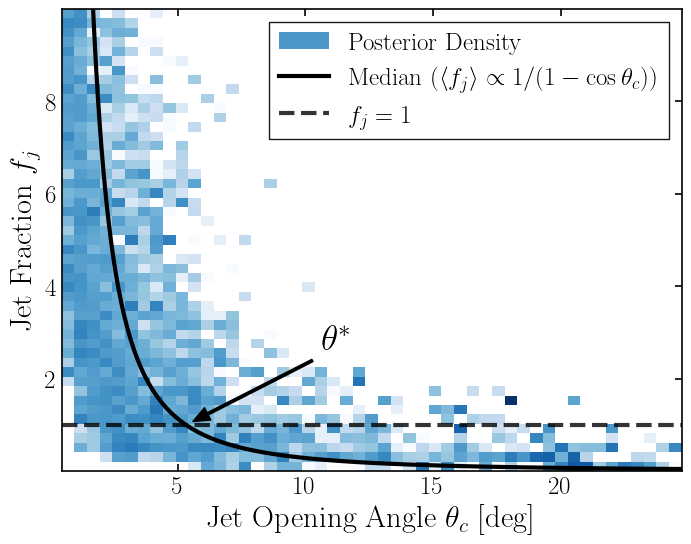

In [ ]:
samples             = backend.get_chain(discard=300, thin=15, flat=True)
x_vals              = samples[:, 4]  # Index 4 is theta_c_deg
y_vals              = samples[:, 5]  # Index 5 is f_j
geom_factor         = 1 - np.cos(np.radians(x_vals))
epsilon_samples     = y_vals * geom_factor
eps_med_unbiased    = np.median(epsilon_samples)
theta_star_rad      = np.arccos(1 - eps_med_unbiased)
theta_star          = np.degrees(theta_star_rad)

fig, ax = plt.subplots(figsize=(8, 6))

lin_bins_x = np.linspace(x_vals.min(), x_vals.max(), 50)
lin_bins_y = np.linspace(y_vals.min(), y_vals.max(), 50)

h = ax.hist2d(x_vals, y_vals, bins=[lin_bins_x, lin_bins_y], cmap='Blues', density=True, norm=mcolors.LogNorm(), cmin=1e-5)

x_line      = np.logspace(np.log10(x_vals.min()), np.log10(x_vals.max()), 100)
x_line_rad  = np.radians(x_line)
y_line      = eps_med_unbiased / (1 - np.cos(x_line_rad))
line,       = ax.plot(x_line, y_line, color='black', linestyle='-', linewidth=3, label=r'Median ($\left<f_j \right> \propto 1/(1 - \cos\theta_c$))')
line2       = ax.axhline(1, color='k', linestyle='--', alpha=0.8, linewidth=3, label=r'$f_j = 1$')

ax.annotate(r'$\theta^*$', xy=(theta_star, 1), 
    xytext=(theta_star * 2, 2.5), 
    arrowprops=dict(facecolor='black', shrink=0.05, width=1.8, headwidth=10),
    fontsize=26, fontweight='bold', verticalalignment='bottom'
)

legend_elements = [Patch(facecolor=plt.cm.Blues(0.6), edgecolor='none', label='Posterior Density'), line, line2]
ax.legend(handles=legend_elements, fontsize=18, loc='upper right')
ax.set_xlabel(r'Jet Opening Angle $\theta_c$ [deg]', fontsize=22)
ax.set_ylabel(r'Jet Fraction $f_j$', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=18)
save_path = output_dir_eps / "degeneracy_concept_plot.pdf"
plt.savefig(save_path, dpi=300)
print(f"Saved plot to {save_path}")

plt.show()

# Flat Theta

In [ ]:
N_PARAMS    = 6
PARAM_NAMES = ["A_index", "L_L0", "L_mu_E", "sigma_E", "theta_c_max", "fj"]

def log_prior_ft(thetas, max_fj = 10):
    A_index, L_L0, L_mu_E, sigma_E, theta_c_max, fj = thetas
    
    if not (1.5 < A_index < 12): return -inf
    if not (-2 < L_L0 < 7): return -inf
    if not (0.1 < L_mu_E < 7): return -inf
    if not (0 < sigma_E < 2.5): return -inf
    if not (1 < theta_c_max < 25): return -inf
    if not (0 < fj < max_fj): return -inf
    
    return 0.0

def log_likelihood_flat_theta(thetas, params_in, distances, k_interpolator, n_events=10_000):
    theta_c_max, fj             = thetas[4], thetas[5]
    gbm_eff                     = 0.6
    geometric_efficiency        = calculate_geometric_efficiency_flat(theta_c_max)
    triggered_years             = params_in.triggered_years
    epsilon                     = geometric_efficiency * fj
    n_years                     = triggered_years
    intrinsic_rate_per_year     = epsilon * len(params_in.z_arr) * gbm_eff
    expected_events             = intrinsic_rate_per_year * n_years
    results                     = simplified_montecarlo(thetas, n_events, params_in, distances, k_interpolator)
    trigger_mask, analysis_mask = apply_detection_cuts(results["p_flux"], results["E_p_obs"])
    
    if np.sum(analysis_mask) <= 3:
        return -inf, -inf, -inf, -inf, -inf
    
    triggered_events        = np.sum(trigger_mask)
    physics_efficiency      = triggered_events  / n_events
    predicted_detections    = expected_events * physics_efficiency
    observed_detections     = params_in.yearly_rate * params_in.triggered_years

    l1 = score_func_cvm(results["p_flux"][analysis_mask], params_in.pflux_data, params_in.rng)
    l2 = score_func_cvm(results["E_p_obs"][analysis_mask], params_in.epeak_data, params_in.rng)
    l3 = poiss_log(k=observed_detections, mu=predicted_detections)

    return l1 + l2 + l3, l1, l2, l3, physics_efficiency

def initialize_walkers_ft(n_walkers):
    np.random.seed(42)
    return np.column_stack([
        np.random.uniform(2, 3, n_walkers),
        np.random.uniform(2, 4.0, n_walkers),
        np.random.uniform(2.0, 4.0, n_walkers),
        np.random.uniform(0.2, 1, n_walkers),
        np.random.uniform(1, 10, n_walkers),    # theta_c_max
        np.random.uniform(0.5, 4, n_walkers),   # fj
    ])

In [ ]:
# Where to find the datafiles and save the outputs
output_dir_ft  = src.init.create_run_dir(f"run_test_top_hat_flat_theta")

default_params, _, data_dict = src.init.initialize_simulation(datafiles, params=params) #? Catalogue data from fermi GBM

print(f"Total events in the catalogue: {len(default_params.pflux_data)}")

n_walkers       = 20
n_steps         = 600

k_interpolator  = create_k_interpolator()
initial_walkers = initialize_walkers_ft(n_walkers)

log_likelihood_default_in_ft = create_log_probability_function(
    log_prior_func          =   log_prior_ft,
    log_likelihood_func     =   log_likelihood_flat_theta,
    params_in               =   default_params,
    k_interpolator          =   k_interpolator
)

filename    = output_dir_ft / "emcee.h5"
initial_pos, n_steps, backend = check_and_resume_mcmc(
    filename                    =   filename, 
    n_steps                     =   n_steps, 
    initialize_walkers_func     =   initialize_walkers_ft, 
    n_walkers                   =   n_walkers
)

sampler = run_mcmc(
    log_probability_func    =   log_likelihood_default_in_ft,
    initial_walkers         =   initial_pos,
    n_iterations            =   n_steps,
    n_walkers               =   n_walkers,
    n_params                =   N_PARAMS,
    backend                 =   backend,
)

Loading existing directory  : Output_files/Paper_Results/Flat_Theta/fiducial
Using redshift model: samples_fiducial_Hrad_A1.0_BNSs_0.dat with 359079 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
Total events in the catalogue: 268
Already completed this run


0it [00:00, ?it/s]


In [ ]:
# Make sure we're using the backend from the flat_theta run
backend_ft  = emcee.backends.HDFBackend(output_dir_ft / "emcee.h5")

plotter_flat_theta = TopHatPlotter(
    backend     =   backend_ft,  # Use explicit backend variable
    output_dir  =   output_dir_ft,
    model_type  =   "flat_theta",
    burn_in     =   1000,
    thin        =   15
)   

# Generate all plots
distances = compute_luminosity_distance(default_params.z_arr)
summary = plotter_flat_theta.generate_all_plots(
    mc_func=simplified_montecarlo,
    params_in=default_params,
    distances=distances,
    k_interpolator=k_interpolator,
    geometric_eff_func=calculate_geometric_efficiency_flat
)
print(summary)

Generating corner plot...
(78660, 6)
Generating likelihood evolution...
Generating autocorrelation plot...
Generating corner plot for last two parameters...
Generating CDF comparison...
All plots saved to: Output_files/Paper_Results/Flat_Theta/fiducial
\begin{tabular}{lc}
\hline
Parameter & Value \\
\hline
$k$ & $6.127_{-2.836}^{+3.757}$ \\
$\log_{10}(L_0)$ & $3.153_{-0.480}^{+0.429}$ \\
$\log_{10}(\mu_E)$ & $3.425_{-0.171}^{+0.373}$ \\
$\sigma_E$ & $0.394_{-0.085}^{+0.155}$ \\
$\theta_{c,\max}$ (deg) & $4.197_{-2.365}^{+5.036}$ \\
$f_j$ & $2.827_{-2.156}^{+3.876}$ \\
\hline
\end{tabular}


# Log-Normal

In [69]:
from src.top_hat.montecarlo import *

N_PARAMS        = 6
PARAM_NAMES     = ["A_index", "L_L0", "L_mu_E", "sigma_E", "theta_c_med", "fj"]

def log_prior_log_normal(thetas):
    # Change the variable name from theta_c_med_10 to theta_c_med
    A_index, L_L0, L_mu_E, sigma_E, theta_c_med, fj = thetas

    if not (1.5 < A_index       < 12): return -inf
    if not (-2  < L_L0          < 7): return -inf
    if not (0.1 < L_mu_E        < 7): return -inf
    if not (0   < sigma_E       < 2.5): return -inf
    if not (1   < theta_c_med   < 25): return -inf
    if not (0   < fj            < 1): return -inf
    
    return 0.0


from scipy.interpolate import interp1d
def create_geometric_efficiency_lognormal_interpolator(sigma_theta_c=0.5, n_points=200):
    """
    Create an interpolator for lognormal geometric efficiency.
    
    Call this once before MCMC, then use the returned function.
    """
    theta_c_med_grid = np.linspace(1, 25, n_points)
    
    efficiencies = np.array([
        _calculate_geometric_efficiency_lognormal_raw(t, sigma_theta_c) 
        for t in theta_c_med_grid
    ])
    
    return interp1d(theta_c_med_grid, efficiencies, kind='cubic', 
                    bounds_error=False, fill_value=(efficiencies[0], efficiencies[-1]))

def _calculate_geometric_efficiency_lognormal_raw(theta_c_med, sigma_theta_c=0.5):
    """Raw calculation - use interpolator version in MCMC."""
    mu      = np.log(theta_c_med)
    sigma   = sigma_theta_c * np.log(10)
    
    shape = sigma
    scale = np.exp(mu)

    theta_c_min = 1
    theta_c_max = 45

    cdf_max = lognorm.cdf(theta_c_max, s=shape, scale=scale)
    cdf_min = lognorm.cdf(theta_c_min, s=shape, scale=scale)
    norm    = cdf_max - cdf_min
    if norm <= 1e-9:
        return 0.0

    def integrand(theta_c_deg):
        # theta_c_deg in degrees, between 1 and 90
        theta_c_rad = np.deg2rad(theta_c_deg)
        detection_prob = 1.0 - np.cos(theta_c_rad)
        pdf = lognorm.pdf(theta_c_deg, s=shape, scale=scale) # use scipy's lognorm.pdf for numerical stability
        return detection_prob * pdf

    # integrate ordinary lognormal from small val to 90 deg
    geometric_eff_raw, _ = quad(integrand, theta_c_min, theta_c_max, epsabs=1e-8, epsrel=1e-8)
    # divide by CDF() to get truncated expectation
    return geometric_eff_raw / norm

geom_eff_interp = create_geometric_efficiency_lognormal_interpolator(sigma_theta_c=0.5)
def log_likelihood_log_normal(thetas, params_in, distances, k_interpolator, n_events=10_000):
    theta_c_med, fj             = thetas[4], thetas[5]
    
    gbm_eff                     = 0.6
    geometric_efficiency        = geom_eff_interp(theta_c_med)
    triggered_years             = params_in.triggered_years
    epsilon                     = geometric_efficiency * fj

    factor                      = 1 # Simulate less as the effieicny is already making this hella slow
    n_years                     = triggered_years / factor
    intrinsic_rate_per_year     = epsilon * len(params_in.z_arr) * gbm_eff
    expected_events             = intrinsic_rate_per_year * n_years
    #n_events                    = int(expected_events)
    
    results                     = simplified_montecarlo(thetas, n_events, params_in, distances, k_interpolator)
    
    trigger_mask, analysis_mask = apply_detection_cuts(results["p_flux"], results["E_p_obs"])
    
    if np.sum(analysis_mask) <= 3:
        return -inf, -inf, -inf, -inf, -inf
    
    triggered_events        = np.sum(trigger_mask)
    physics_efficiency      = triggered_events  / n_events
    
    predicted_detections    = expected_events * physics_efficiency
    observed_detections     = params_in.yearly_rate * params_in.triggered_years
    
    l1 = score_func_cvm(results["p_flux"][analysis_mask], params_in.pflux_data, params_in.rng)
    l2 = score_func_cvm(results["E_p_obs"][analysis_mask], params_in.epeak_data, params_in.rng)
    l3 = poiss_log(k=observed_detections, mu=predicted_detections)
        
    return l1 + l2 + l3, l1, l2, l3, physics_efficiency

# log_likelihood similar to flat case but uses calculate_geometric_efficiency_lognormal

def initialize_walkers_log_normal(n_walkers):
    np.random.seed(42)
    return np.column_stack([
        np.random.uniform(2, 3, n_walkers),
        np.random.uniform(2, 4.0, n_walkers),
        np.random.uniform(2.0, 4.0, n_walkers),
        np.random.uniform(0.2, 1, n_walkers),
        np.random.uniform(5, 10, n_walkers),  
        np.random.uniform(0.5, 1, n_walkers),
    ])

In [ ]:
output_dir_lm                       = src.init.create_run_dir(f"Paper_Results/Lognormal_Theta_FP/fiducial")
n_walkers                           = 20
n_steps                             = 600

log_likelihood_default_in_log_normal = create_log_probability_function(
    log_prior_func          =   log_prior_log_normal,
    log_likelihood_func     =   log_likelihood_log_normal,
    params_in               =   default_params,
    k_interpolator          =   k_interpolator
)

initial_pos, n_steps, backend = check_and_resume_mcmc(
    filename                    =    output_dir_lm / "emcee.h5", 
    n_steps                     =   n_steps, 
    initialize_walkers_func     =   initialize_walkers_log_normal, 
    n_walkers                   =   n_walkers
) 

sampler = run_mcmc(
    log_probability_func    =   log_likelihood_default_in_log_normal,
    initial_walkers         =   initial_pos,
    n_iterations            =   n_steps,
    n_walkers               =   n_walkers,
    n_params                =   N_PARAMS,
    backend                 =   backend,
)

Using redshift model: samples_fiducial_Hrad_A1.0_BNSs_0.dat with 359079 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
Total events in the catalogue: 268
Already completed this run


0it [00:00, ?it/s]


In [77]:
# plot
backend_ln = emcee.backends.HDFBackend(output_dir_lm / "emcee.h5")

plotter_log_normal = TopHatPlotter(
    backend     =   backend_ln,
    output_dir  =   output_dir_lm,
    model_type  =   "lognormal_theta_flat",
    burn_in     =   30_000,
    thin        =   15
)

# Generate all plots
distances = compute_luminosity_distance(default_params.z_arr)
summary = plotter_log_normal.generate_all_plots(
    mc_func=simplified_montecarlo,
    params_in=default_params,
    distances=distances,
    k_interpolator=k_interpolator,
    geometric_eff_func=geom_eff_interp
)

print(summary)  # Print LaTeX table

Generating corner plot...
(93320, 6)
Generating likelihood evolution...
Generating autocorrelation plot...
Generating corner plot for last two parameters...
Generating CDF comparison...
All plots saved to: Output_files/Paper_Results/Lognormal_Theta_FP/fiducial
\begin{tabular}{lc}
\hline
Parameter & Value \\
\hline
$k$ & $7.067_{-3.584}^{+3.417}$ \\
$\log_{10}(L_0)$ & $2.975_{-0.474}^{+0.542}$ \\
$\log_{10}(\mu_E)$ & $3.493_{-0.229}^{+0.667}$ \\
$\sigma_E$ & $0.429_{-0.110}^{+0.244}$ \\
$\theta_{c,\mathrm{med}}$ & $9.154_{-6.673}^{+9.872}$ \\
$f_j$ & $0.218_{-0.161}^{+0.442}$ \\
\hline
\end{tabular}
